In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure

In [2]:
#Q1 (70 %) Implement investment strategies in Python:

In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal,final_weight

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port/len(cur_prices)/cur_prices #precise number of shares ~= 1/20 weight

    #calculate the transaction cost
    #call the rounding function to get the first estimated x_optimal
    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices)) 
        position_diff=number_share_round-x_init
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1

    x_optimal=number_share_round
    cash_optimal=cash_temp
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal,final_weight

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices): 
    #initialize the CPLEX Object
    cpx=cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n=len(cur_prices)

   # Define linear part of objective
   # function and bounds on variables
    c=[0.0]*n
    ub=[cplex.infinity]*n
# Define constraint matrix A
    cols=[[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],
        [[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]]]
# Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs =[1.0], senses="E")
    cpx.variables.add(obj=c, ub=ub , columns=cols, names=["w1", "w2", "w3","w4", "w5", "w6","w7", "w8", "w9","w10", "w11",
                                                     "w12","w13", "w14", "w15","w16", "w17", "w18","w19","w20"])
# Define and add quadratic part of objective function
    Sparse = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Sparse)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.solve()
    
    weight=cpx.solution.get_values()
    weight_to_array=np.array(weight) 
    #up to this.. get the weight array for each stock, next is similar to equal weight strategy
 
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp    
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal,final_weight

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #initialize the CPLEX Object
    cpx=cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n=len(cur_prices)
   # Define linear part of objective
   # function and bounds on variables
    c=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    ub=[cplex.infinity]*len(cur_prices) #put k here
    cols=[]
# Define constraint matrix A
 #Define the linear constraint for  1/(mu-rf) and transform the sparse matrix 
    mu_=mu-1/252*r_rf
    for k in range(20):
        cols.append([[0],[mu_[k]]])    
# Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs =[1.0], senses="E") #put k in 2nd spot
    cpx.variables.add(obj=c, ub=ub , columns=cols, names=["y1", "y2", "y3","y4", "y5", "y6","y7", "y8", "y9","y10", "y11",
                                                     "y12","y13", "y14", "y15","y16", "y17", "y18","y19","y20"])

# Define and add quadratic part of objective function
    Sparse = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(Sparse)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.solve()
    y_=cpx.solution.get_values() # this is vector y
    y_array=np.array(y_) 
    weight=y_array/np.sum(y_array) #convert to weight vector
    #up to this.. get the weight array for each stock, next is similar to min_variance
 
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal,final_weight

def rounding (x_position_raw,times,number_of_stock):
    number_share_round=np.zeros(number_of_stock)
    for i in range(number_of_stock):
        number_share_round[i]=math.floor(x_position_raw[i])-times
        if number_share_round[i]<0: # round up to 0 if it is negative number
            number_share_round[i]=0
    
    return number_share_round

In [4]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat =len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
weight_opt = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1] = fh_array[strategy](curr_positions, 
                                                                           curr_cash, mu, Q, cur_prices)



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
    

##Q2 (20 %) Analyze your results:
#Produce the following output for the 12 periods (years 2020 and 2021):



Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990890.03, value end = $ 892446.80
  Strategy "Mininum Variance Portfolio", value begin = $ 992757.75, value end = $ 915865.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.02, value end = $ 922031.08

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 930705.94, value end = $ 861861.09
  Strategy "Mininum Variance Portfolio", value begin = $ 955711.75, value end = $ 850653.48
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 961934.80, value end = $ 1017089.44

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
 

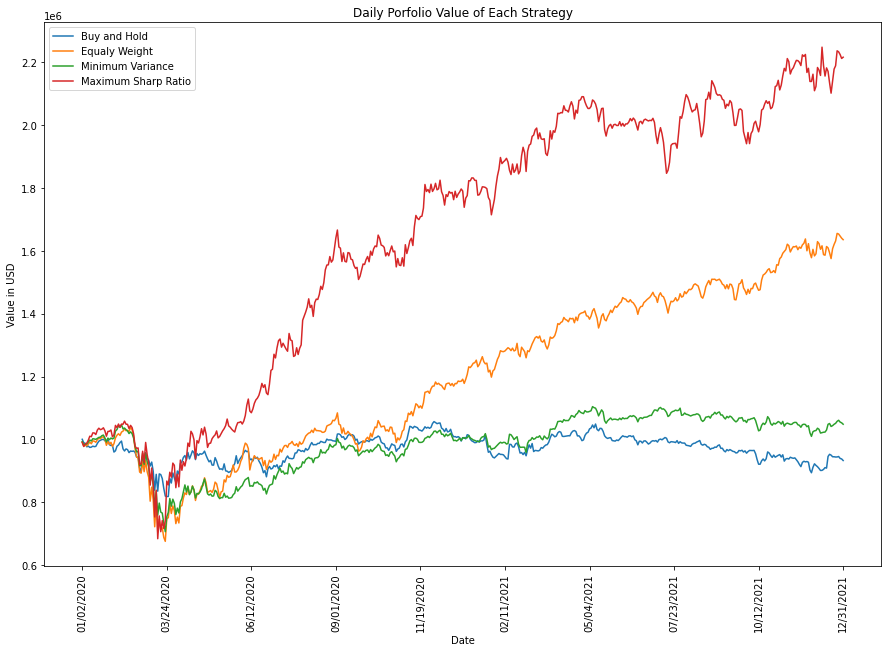

In [5]:
#Q2 (20 %) Analyze your results:
# Plot results
# one plot show daily portfolio for all strategy

plt.figure(figsize=(15,10))

plt.xlabel('Date')
plt.ylabel('Value in USD')
plt.plot(dates,portf_value[0],label='Buy and Hold')
plt.plot(dates,portf_value[1],label='Equaly Weight')
plt.plot(dates,portf_value[2],label='Minimum Variance')
plt.plot(dates,portf_value[3],label='Maximum Sharp Ratio')
plt.title('Daily Porfolio Value of Each Strategy')
plt.xticks(list(dates[k] for k in list(np.linspace(0,504,10,dtype=int))),rotation=90)
plt.legend()
plt.show()

In [6]:
    # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
# each strategy function has implemented while loop to check if the remain CA cash account is positive..
# here is just to show this is hold by showing the cash array, it is all postivie
cash

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1684.8566966915969, 3997.147075617453, 4521.5974137117155,
        4949.418017673655, 7087.652822425473, 10561.651681482908,
        13097.13060613873, 15912.735898230108, 19183.55266506446,
        24200.34431271802, 26831.5262870671, 31243.294032523758],
       [1115.910209636786, 91.82063468231354, 529.695198938949,
        472.3650456428295, 1835.8097711943556, 145.70498405443504,
        2871.1560396193527, 3398.7846925543854, 243.56248529430013,
        566.5903973769164, 5565.887363219052, 5068.600431418163],
       [296.19903583533596, 13.93597646721173, 389.122475643293,
        664.1903010226088, 1870.4628222800093, 91.76077568309847,
        409.78309323091526, 1595.8356512860628, 3486.6291498307837,
        42.945823071408086, 334.47012855799403, 208.4439001682913]],
      dtype=object)

In [7]:
df

,Date,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,...,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,11/01/2019,62.830284,34.889999,1791.439941,30.219509,44.458351,68.872787,43.913418,8.697544,1273.739990,...,16.557255,115.847466,53.451176,119.583778,44.877628,140.553009,50.482697,61.439999,33.252583,54.673573
1,11/04/2019,63.242893,36.290001,1804.660034,30.789696,45.928978,70.094673,44.333599,8.805162,1291.369995,...,16.762127,117.676674,54.491642,120.538200,46.299908,141.364716,52.453751,61.570000,33.201363,54.220749
2,11/05/2019,63.152023,36.150002,1801.709961,31.188820,46.353199,69.796196,44.595039,8.824731,1292.030029,...,17.134619,117.864723,54.434879,120.800194,46.224052,141.276703,52.231976,61.439999,33.440399,53.885662
3,11/06/2019,63.179035,35.930000,1795.770020,31.160311,46.315498,69.413773,45.071243,8.726894,1291.800049,...,18.224154,118.625473,54.782028,120.987350,46.043892,140.885498,51.738590,60.730000,33.508701,54.456219
4,11/07/2019,63.908203,36.279999,1788.199951,31.578445,46.570034,70.710266,45.211308,8.697544,1308.859985,...,18.056536,119.083855,55.210014,121.642342,46.138710,141.081085,51.915520,60.400002,33.653831,54.818470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,12/27/2021,180.330002,154.360001,3393.389893,44.639999,58.520000,60.650002,63.048477,20.799999,2961.280029,...,38.099998,131.619995,51.939999,157.217621,100.400002,342.450012,309.450012,127.209999,24.286488,52.052856
542,12/28/2021,179.289993,153.149994,3413.219971,44.700001,58.459999,60.619999,63.157833,20.760000,2928.959961,...,37.950001,132.630005,51.759998,157.694748,99.970001,341.250000,303.220001,127.480003,24.325691,52.092381
543,12/29/2021,179.380005,148.259995,3384.020020,44.630001,58.369999,60.540001,63.585312,20.559999,2930.090088,...,37.980000,133.350006,51.830002,157.615234,98.730003,341.950012,300.010010,126.690002,24.149275,51.736668
544,12/30/2021,178.199997,145.149994,3372.889893,44.529999,57.970001,60.430000,63.247307,20.469999,2920.050049,...,37.750000,133.910004,51.740002,157.535706,98.800003,339.320007,295.859985,125.919998,24.286488,51.627975


In [8]:
##Q2 (20 %) Analyze your results:
#Plot two charts for Strategy 3 and 4 to show the Dynamic change

# x is the position for each stratgy(3 and 4) and each period (12 in total, from 0 to 11)
x[2][0]

array([6.190e+02, 0.000e+00, 4.000e+00, 0.000e+00, 2.205e+03, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.080e+02, 9.700e+02,
       0.000e+00, 0.000e+00, 0.000e+00, 1.366e+03, 0.000e+00, 2.914e+03,
       6.050e+02, 4.889e+03])

In [9]:
# weight_opt is the weight for each stratgy(3 and 4) and each period (12 in total,from 0 to 11)
weight_opt[2] #weights for strategy 3, it contains 12 elements, each element represents each period 

array([array([0.04618488, 0.        , 0.00765603, 0.        , 0.10673864,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.01197319, 0.11456454, 0.        , 0.        , 0.        ,
              0.21711696, 0.        , 0.20293701, 0.0202405 , 0.27258824]),
       array([0.        , 0.        , 0.        , 0.        , 0.09253552,
              0.        , 0.        , 0.16359892, 0.        , 0.1111231 ,
              0.10532829, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.52741417]),
       array([0.        , 0.        , 0.23528772, 0.        , 0.        ,
              0.        , 0.        , 0.02628899, 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.73842328]),
       array([0.        , 0.        , 0.46447961, 0.        , 0.        ,
              0.        , 0.    

In [10]:
stock_name=df.columns[1:]
stock_name

Index(['AAPL', 'AMD', 'AMZN', 'BAC', 'BK', 'C', 'CSCO', 'F', 'GOOG', 'HOG',
       'HPQ', 'IBM', 'INTC', 'JPM', 'MS', 'MSFT', 'NVDA', 'SONY', 'T', 'VZ'],
      dtype='object')

In [11]:
df_stra3=pd.DataFrame(weight_opt[2].tolist(),columns=stock_name)
df_stra3

,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,HOG,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,0.046185,0.000000,0.007656,0.000000,0.106739,0.000000,0.000000,0.000000,0.000000,0.000000,0.011973,0.114565,0.000000,0.0,0.000000,0.217117,0.000000,0.202937,0.020241,0.272588
1,0.000000,0.000000,0.000000,0.000000,0.092536,0.000000,0.000000,0.163599,0.000000,0.111123,0.105328,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.527414
2,0.000000,0.000000,0.235288,0.000000,0.000000,0.000000,0.000000,0.026289,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.738423
3,0.000000,0.000000,0.464480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.113163,0.000000,0.422357
4,0.016288,0.002914,0.000000,0.055842,0.000000,0.000000,0.024606,0.000000,0.062650,0.000000,0.000000,0.000000,0.040891,0.0,0.000000,0.055924,0.000000,0.056011,0.056677,0.628195
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040196,0.0,0.000000,0.000000,0.000000,0.194575,0.088158,0.677071
6,0.000000,0.021034,0.085997,0.000000,0.000000,0.006591,0.000000,0.000000,0.000000,0.027184,0.000000,0.000000,0.000000,0.0,0.000000,0.044450,0.093241,0.029206,0.054163,0.638133
7,0.000000,0.000000,0.055064,0.000000,0.000000,0.000000,0.048562,0.000000,0.000000,0.013647,0.241556,0.025913,0.000000,0.0,0.000000,0.132871,0.000000,0.001558,0.265095,0.215735
8,0.017842,0.000000,0.168249,0.000000,0.078450,0.000000,0.000000,0.000000,0.000000,0.024404,0.000000,0.000000,0.000000,0.0,0.082276,0.105259,0.000000,0.000000,0.260875,0.262645
9,0.000000,0.049711,0.242577,0.000000,0.058694,0.028106,0.000000,0.027683,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.037818,0.000000,0.555411


Text(0.5, 1.0, 'Strategy - Minimum Variance Dynamic Changes in Portfolio over Period ')

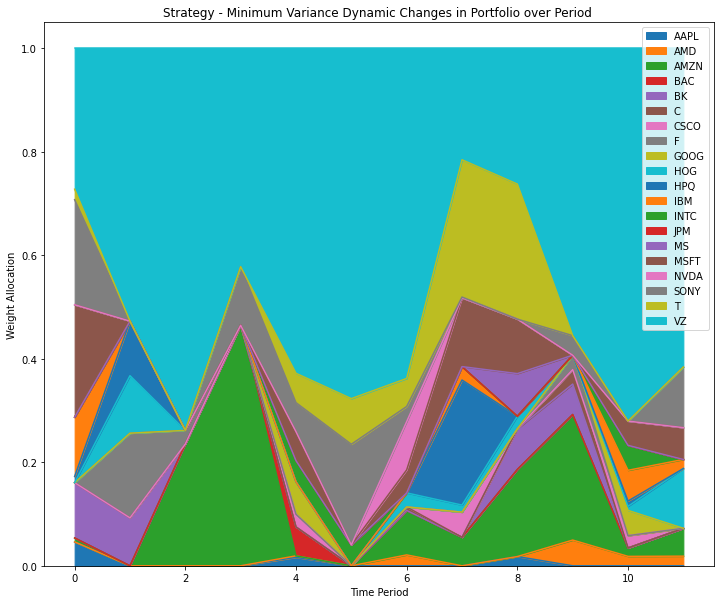

In [12]:

ax=df_stra3.plot.area(figsize=(12,10),label='a')
ax.legend(loc='best')
ax.set_xlabel("Time Period")
ax.set_ylabel("Weight Allocation")
ax.set_title('Strategy - Minimum Variance Dynamic Changes in Portfolio over Period ')

In [13]:
df_stra4=pd.DataFrame(weight_opt[3].tolist(),columns=stock_name)
df_stra4

,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,HOG,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,0.200862,0.055114,0.000000,0.066988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157682,0.000000,0.0,0.000000,0.000000,0.162111,0.000000,0.357243,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.441055,0.000000,0.410961,0.000000,0.000000,0.000000,0.000000,0.027660,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.003836,0.000000,0.116488,0.000000,0.000000,0.000000
4,0.153454,0.058468,0.000000,0.034860,0.000000,0.000000,0.000000,0.068080,0.029372,0.027072,0.000000,0.000000,0.0,0.099987,0.000000,0.000000,0.129153,0.000000,0.000000,0.399553
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.491188,0.000000,0.123863,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.384949,0.000000,0.000000
6,0.194954,0.126950,0.000000,0.000000,0.000000,0.163822,0.038951,0.000000,0.000000,0.000000,0.289454,0.000000,0.0,0.000000,0.029407,0.000000,0.000000,0.156461,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205588,0.090876,0.000000,0.412708,0.000000,0.0,0.221825,0.000000,0.069002,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.163550,0.009384,0.113946,0.000000,0.000000,0.000000,0.105158,0.094545,0.000000,0.083239,0.0,0.000000,0.000000,0.000000,0.027923,0.000000,0.402254,0.000000
9,0.000000,0.252271,0.000000,0.000000,0.000000,0.000000,0.000000,0.261739,0.000000,0.000000,0.000000,0.109104,0.0,0.000000,0.040211,0.000000,0.336676,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Strategy - Maximum Sharp Ratio Dynamic Changes in Portfolio over Period ')

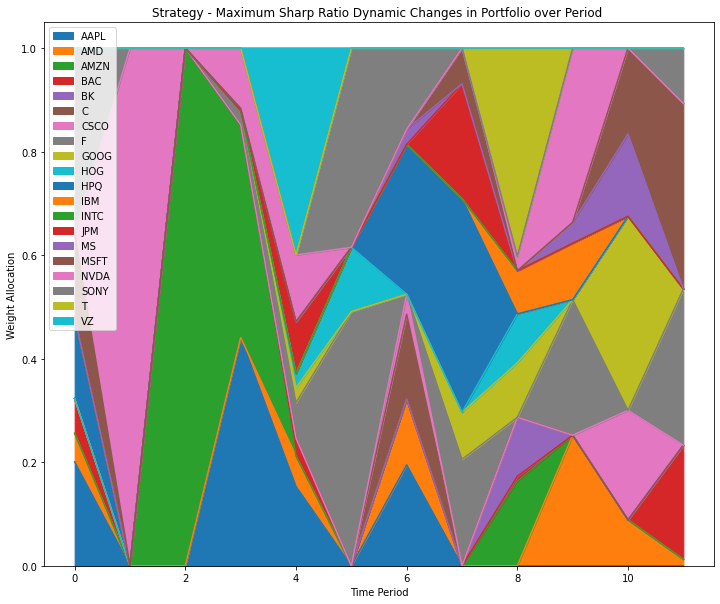

In [14]:
ax2=df_stra4.plot.area(figsize=(12,10),label='a')
ax2.legend(loc='best')
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Weight Allocation")
ax2.set_title('Strategy - Maximum Sharp Ratio Dynamic Changes in Portfolio over Period ')

In [15]:
# Q3. (10 %) Discuss possible improvements to your trading strategies:

# first period 1/n then buy and hold


In [18]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio']
N_strat = 1  # comment this in your code
#N_strat =len(strategy_functions)  # uncomment this in your code

portf_value = [0] * N_strat
weight_opt = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
         
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1] = strat_equally_weighted(curr_positions, curr_cash, mu, Q, cur_prices)

      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1] =strat_buy_and_hold(curr_positions,curr_cash, mu, Q, cur_prices)



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( 'Equal Weight then Hold', 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Equal Weight then Hold", value begin = $ 990890.03, value end = $ 892446.80

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Equal Weight then Hold", value begin = $ 931095.81, value end = $ 868625.56

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Equal Weight then Hold", value begin = $ 837891.75, value end = $ 944418.95

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Equal Weight then Hold", value begin = $ 940808.89, value end = $ 1096356.23

Period 5: start date 09/01/2020, end date 10/30/2020
  Strategy "Equal Weight then Hold", value begin = $ 1107631.55, value end = $ 1019004.77

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Equal Weight then Hold", value begin = $ 1026138.49, value end = $ 1198485.54

Period 7: start date 01/04/2021, end date 02/26/2021
  Strategy "Equal Weight then Hold", value begin

In [19]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio']
N_strat = 1  # comment this in your code
#N_strat =len(strategy_functions)  # uncomment this in your code

portf_value = [0] * N_strat
weight_opt = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
         
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1] = strat_max_Sharpe(curr_positions, curr_cash, mu, Q, cur_prices)

      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1] =strat_buy_and_hold(curr_positions,curr_cash, mu, Q, cur_prices)



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( 'Sharp Ratio then Hold', 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 990063.42, value end = $ 937639.97

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 986015.59, value end = $ 917468.38

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 892286.86, value end = $ 992409.97

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 979870.35, value end = $ 1164465.07

Period 5: start date 09/01/2020, end date 10/30/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 1183366.22, value end = $ 1022356.78

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Sharp Ratio then Hold", value begin = $ 1029378.16, value end = $ 1229898.00

Period 7: start date 01/04/2021, end date 02/26/2021
  Strategy "Sharp Ratio then Hold", value begin = $ 12